In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [3]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train = train[:1000]
print(train)

     label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0        1       0       0       0       0       0       0       0       0   
1        0       0       0       0       0       0       0       0       0   
2        1       0       0       0       0       0       0       0       0   
3        4       0       0       0       0       0       0       0       0   
4        0       0       0       0       0       0       0       0       0   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
995      2       0       0       0       0       0       0       0       0   
996      5       0       0       0       0       0       0       0       0   
997      9       0       0       0       0       0       0       0       0   
998      6       0       0       0       0       0       0       0       0   
999      4       0       0       0       0       0       0       0       0   

     pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel

In [6]:
x_train = train.drop(columns=['label']).values/255
y_train = train['label'].values
x_test = test.values/255

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

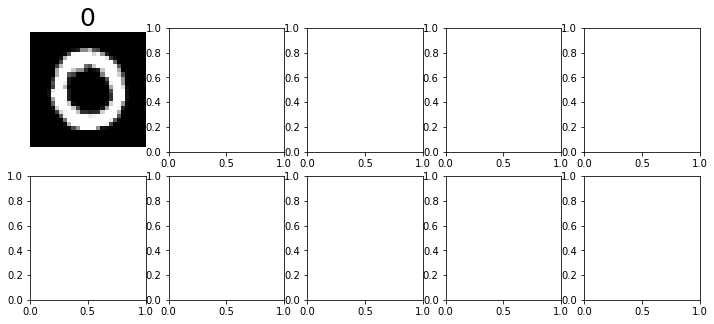

In [8]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten() 
idx = np.random.randint(0,10,size=10) 
for i in range(10):
    axes[i].imshow(x_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') 
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25) 
    plt.show()

In [10]:
print(len(test))

28000


In [11]:
def relu(x):
    x[x<0]=0
    return x

In [12]:
def h(X,W,b):
    a1 = X
    z1 = np.matmul(X, W[0]) + b[0]
    
    aa = relu(z1)
    zz = np.matmul(aa,W[1]) + b[1]
    
    a2 = relu(zz)
    z2 = np.matmul(a2, W[2])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    sigma = s/total
    return sigma

In [13]:
def softmax(X_in,weights):
    
    s = np.exp(np.matmul(X_in,weights))
    total = np.sum(s, axis=1).reshape(-1,1)
    return s / total

In [14]:
def loss(y_pred,y_true):
    global K 
    K = 10
    N = len(y_true)
    y_true_one_hot_vec = (y_true[:,np.newaxis] == np.arange(K))
    loss_sample = (np.log(y_pred) * y_true_one_hot_vec).sum(axis=1)
    return -np.mean(loss_sample)

In [15]:
def backprop(W,b,X,y,alpha=1e-4):
    K = 10
    N = X.shape[0]
    
    a1 = X
    z1 = np.matmul(X, W[0]) + b[0]
    
    aa = relu(z1)
    zz = np.matmul(aa, W[1]) + b[1]
    
    a2 = relu(zz)
    
    z2 = np.matmul(a2, W[2])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    sigma = s/total
    
    y_one_hot_vec = (y[:,np.newaxis] == np.arange(K))
    delta2 = (sigma - y_one_hot_vec)
    grad_W1 = np.matmul(a2.T, delta2)
    
    delta_add = np.matmul(delta2, W[2].T)*(zz>0)
    grad_W_add = np.matmul(aa.T, delta_add)
    
    delta1 = np.matmul(delta_add,W[1].T)*(z1>0)
    grad_W0 = np.matmul(X.T, delta1)
    
    dW = [grad_W0/N + alpha*W[0], grad_W_add/N + alpha*W[1], grad_W1/N + alpha*W[2]]
    db = [np.mean(delta1, axis=0), np.mean(delta_add, axis=0)]
    return dW, db

In [16]:
eta = 5e-1
alpha = 1e-6 # regularization
gamma = 0.99 # RMSprop
eps = 1e-3 # RMSprop
max_iter = 2000 # number of iterations of gradient descent
n_H = 256 # number of neurons in the hidden layer
n = x_train.shape[1] # number of pixels in an image
K = 10

In [17]:
np.random.seed()
W = [1e-1*np.random.randn(n, n_H), 1e-1*np.random.randn(n_H, n_H), 1e-1*np.random.randn(n_H, K)]
b = [np.random.randn(n_H), np.random.randn(n_H)]

In [18]:
import time
err = 1e-5

In [33]:
def train_model(x_train,y_train):

    score = 0
    batch_size = 2000
    num_batches = int((np.divide(x_train.shape[0], batch_size)))
    print(num_batches)
    X_batches = np.split(x_train,num_batches)
    y_batches = np.split(y_train,num_batches)

    time0 = time.time()
    gW0 = gW1 = gb0 = gW2 = gb1 = 1

    for i in range(2000):

        for batch_index in range(0,num_batches):
            dW, db = backprop(W,b,X_batches[batch_index],y_batches[batch_index],alpha)


            gW0 = gamma*gW0 + (1-gamma)*np.sum(dW[0]**2)
            etaW0 = eta/np.sqrt(gW0 + eps)
            W[0] -= etaW0 * dW[0]

            gW1 = gamma*gW1 + (1-gamma)*np.sum(dW[1]**2)
            etaW1 = eta/np.sqrt(gW1 + eps)
            W[1] -= etaW1 * dW[1]

            gb0 = gamma*gb0 + (1-gamma)*np.sum(db[0]**2)
            etab0 = eta/np.sqrt(gb0 + eps)
            b[0] -= etab0 * db[0]


            gW2 = gamma*gW2 + (1-gamma)*np.sum(dW[2]**2)
            etaW2 = eta/np.sqrt(gW2 + eps)
            W[2] -= etaW2 * dW[2]

            gb1 = gamma*gb1 + (1-gamma)*np.sum(db[1]**2)
            etab1 = eta/np.sqrt(gb1 + eps)
            b[1] -= etab0 * db[1]
            
            gW0 = gW1 = gb0 = gW2 = gb1 = 1


        if i % 20 == 0:
            
            y_pred = h(x_train,W,b)
            new_score = np.mean(np.argmax(y_pred, axis=1)== y_train)
            print("iter:score:loss ",i,round(new_score,5),round(loss(y_pred,y_train),5),end = "")
            if new_score>0.999999:
                print()
                break
            if new_score - score<=err:
                print("score reach max")
                break
            score = new_score

    y_pred_final = h(x_train,W,b)
    print("Final training accuracy is {:.4%}".format(np.mean(np.argmax(y_pred_final, axis=1)== y_train)))


    print("time: ", time.time()-time0,"s")
    return W,b


W = [1e-1*np.random.randn(n, n_H), 1e-1*np.random.randn(n_H, n_H), 1e-1*np.random.randn(n_H, K)]
b = [np.random.randn(n_H), np.random.randn(n_H)]
W,b = train_model(x_train,y_train)

0


AttributeError: 'int' object has no attribute 'shape'